In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
sns.set()

# Dependent Variables

In [219]:
df = pd.read_csv("Music_preference_prescreening_survey.csv")

# ordinal
ratings = df.iloc[1:, 11:20] # explicit ratings for each genre
importance = df.iloc[1:, 55]

ratings_dict = {
    "Favorite" : 5,
    "Enjoy/Seek out" : 4,
    "Don't mind, but don't seek out" : 3,
    "Aversive/Avoid" : 2,
    "Least Favorite" : 1
}

importance_dict = {
    "Music is my life" : 4,
    "It plays a big role in my life" : 3,
    "It plays a small role in my life" : 2,
    "It plays no role in my life" : 1
}

# categorical
usage = df.iloc[1:, 21:32] # self reported music usage
isInstrmental = [i==i for i in df.iloc[1:, 33]] # if plays an instrument or not
instrument = df.iloc[1:, [i for i in range(33, 53, 4)]]
instrumentLyrics = df.iloc[1:, 56] # instruments vs lyrics
genres = df.iloc[1:, 57:84]
engagement = df.iloc[1:, 84: 100]

# numerial
timeSpent = df.iloc[1:, 54]

In [220]:
# Mapping
for i in range(len(ratings)):
    for j in range(ratings.shape[1]):
        rat = ratings.iloc[i, j]
        if rat in ratings_dict.keys():
            ratings.iloc[i, j] = ratings_dict[rat]
        else:
            ratings.iloc[i, j] = -1

for i in range(len(importance)):
    imp = importance.iloc[i]
    if imp in importance_dict.keys():
        importance.iloc[i] = importance_dict[imp]
    else:
        importance.iloc[i] = -1

for i in range(instrument.shape[1]):
    instrument[instrument.columns[i]] = instrument.iloc[:,i].map(lambda x: 0 if x != x else 1)

instrument = instrument.T.sum().to_frame().rename(columns= {0: 'instrument'})

for i in range(genres.shape[1]):
    genres[genres.columns[i]] = genres.iloc[:,i].map(lambda x: 0 if x != x else 1)

genres = genres.T.sum().to_frame().rename(columns= {0: 'genres'})

for i in range(usage.shape[1]):
    usage[usage.columns[i]] = usage.iloc[:,i].map(lambda x: 0 if x != x else 1)

usage = usage.T.sum().to_frame().rename(columns= {0: 'usage'})

# Independent Variables

In [221]:
ses_area = df.iloc[1:, [-3,-2]]
original_ses = df.iloc[1:, [-3]]

In [222]:
ses_area

,What is your socioeconomic background?,I grew up in a(n) ... area.
1,Upper class,Urban
2,Upper class,Suburban
3,Upper middle class,Urban
4,Middle class,Suburban
5,Upper middle class,Urban
...,...,...
1371,Upper class,Suburban
1372,Upper class,Suburban
1373,Lower middle class,Suburban
1374,Middle class,Urban


In [223]:
ses_dict = {
    'Upper class' : 5,
    'Upper middle class' : 4,
    'Middle class' : 3,
    'Lower middle class' : 2,
    'At or below poverty line' : 1
}

area_dict = {
    'Urban' : 0,
    'Suburban' : -0.5,
    'Rural' : -1
}

In [224]:
# Mapping
for i in range(len(ses_area)):
    ses = ses_area.iloc[i, 0]
    area = ses_area.iloc[i, 1]
    if (ses in ses_dict.keys()) & (area in area_dict.keys()):
        ses_area.iloc[i, 0] = ses_dict[ses] + area_dict[area]
    else:
        ses_area.iloc[i, 0] = -1

for i in range(len(original_ses)):
    cls = original_ses.iloc[i, 0]
    if (cls in ses_dict.keys()):
        original_ses.iloc[i, 0] = ses_dict[cls]
    else:
        original_ses.iloc[i, 0] = -1

ses = ses_area.iloc[:, [0]]

In [225]:
original_ses = original_ses[original_ses[original_ses.columns[0]] != 3].iloc[:, 0].map(lambda x: "Lower" if x < 3 else "upper")

ses_instrument = pd.merge(instrument, original_ses, left_index=True, right_index=True, how='inner')
ses_genre = pd.merge(genres, original_ses, left_index=True, right_index=True, how='inner')
ses_usage = pd.merge(usage, original_ses, left_index=True, right_index=True, how='inner')

# Helper Functions

In [290]:
cols_of_interest = {
    "gender" : "What is your gender?",
    "environment" : "I grew up in a(n) ... area.",
    "race" : "What is your race/ethnicity?",
    "poltics" : "What are your political views? (pick closest)",
    "religion" : "What are your religious views? (pick closest)",
    "instrument" : "How many music instruments do you play?"
}

def clean_instrument(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans and aggregates instrument playing data from the input DataFrame.

    This function selects specific columns related to musical instruments played by respondents,
    converts non-numeric (NaN) values to 0, numeric values to 1, and sums up the total number
    of instruments played by each respondent. The summed value is then added as a new column
    to the original DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing raw data.

    Returns:
    - pd.DataFrame: The original DataFrame with an added 'instrument' column representing the
      total number of instruments played by each respondent.
    """
    # Selecting specified columns for instrument data and initializing with binary representation
    instrument = df.iloc[1:, [i for i in range(33, 53, 4)]]
    for i in range(instrument.shape[1]):
        # Mapping non-numeric to 0 and numeric to 1
        instrument[instrument.columns[i]] = instrument.iloc[:, i].map(lambda x: 0 if x != x else 1)
    # Summing up the number of instruments played by each respondent
    instrument = instrument.T.sum().to_frame().rename(columns={0: 'instrument'})

    # Adding the aggregated instrument data to the original DataFrame
    df["How many music instruments do you play?"] = instrument
    return df

def clean_genres(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans and aggregates musical genre preference data from the input DataFrame.

    This function selects columns related to musical genres, converts non-numeric (NaN)
    values to 0, numeric values to 1, and sums the preferences across genres for each
    respondent. The summed values are returned as a new DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing raw data.

    Returns:
    - pd.DataFrame: A new DataFrame with a single 'genres' column representing the total
      number of genres preferred by each respondent.
    """
    # Selecting and cleaning genre data
    genres = df.iloc[1:, 57:84]
    for i in range(genres.shape[1]):
        genres[genres.columns[i]] = genres.iloc[:, i].map(lambda x: 0 if x != x else 1)
    genres = genres.T.sum().to_frame().rename(columns={0: 'genres'})

    return genres

def clean_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans and aggregates data on the usage of various services or products from the input DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing raw data.

    Returns:
    - pd.DataFrame: A new DataFrame with a 'usage' column, summarizing the total usage count
      across the selected services or products for each respondent.
    """
    # Selecting and cleaning usage data
    usage = df.iloc[1:, 21:32]
    for i in range(usage.shape[1]):
        usage[usage.columns[i]] = usage.iloc[:, i].map(lambda x: 0 if x != x else 1)
    usage = usage.T.sum().to_frame().rename(columns={0: 'usage'})

    return usage

def clean_ses(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans and categorizes socio-economic status (SES) data from the input DataFrame.

    Maps the SES descriptions to numeric values, excludes middle class data, and then categorizes
    the remaining data into 'Upper' or 'Lower' SES groups.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing raw SES data.

    Returns:
    - pd.DataFrame: A new DataFrame with a single column categorizing respondents into 'Upper' or 'Lower'
      SES groups, excluding 'Middle class'.
    """
    # Mapping SES descriptions to numeric values and re-categorizing
    original_ses = df.iloc[1:, [-3]]
    ses_dict = {
        'Upper class': 5,
        'Upper middle class': 4,
        'Middle class': 3,
        'Lower middle class': 2,
        'At or below poverty line': 1
    }
    for i in range(len(original_ses)):
        cls = original_ses.iloc[i, 0]
        original_ses.iloc[i, 0] = ses_dict.get(cls, -1)
    # Excluding 'Middle class' and categorizing into 'Upper' or 'Lower'
    original_ses = original_ses[original_ses[original_ses.columns[0]] != 3].iloc[:, 0].map(lambda x: "Lower" if x < 3 else "Upper").to_frame()

    return original_ses

def join_df_ses(df: pd.DataFrame, ses: pd.DataFrame) -> pd.DataFrame:
    """
    Joins the main DataFrame with the socio-economic status (SES) DataFrame based on their indices.

    Parameters:
    - df (pd.DataFrame): The main DataFrame.
    - ses (pd.DataFrame): The DataFrame containing SES data.

    Returns:
    - pd.DataFrame: The result of an inner join between the main DataFrame and the SES DataFrame.
    """
    # Performing an inner join based on DataFrame indices
    return pd.merge(df, ses, left_index=True, right_index=True, how='inner')

def get_top3_buckets(df: pd.DataFrame, col: str) -> list:
    """
    Identifies the top 3 most common values (buckets) for a specified column in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - col (str): The column name whose top 3 most common values are to be found.

    Returns:
    - list: A list containing the top 3 most common values in the specified column.
    """
    # Accessing the column of interest
    col_name = cols_of_interest[col]
    # Retrieving the top 3 most common values
    return [df[[col_name]].iloc[1:].value_counts().keys()[i][0] for i in range(3)]

def stratification(df: pd.DataFrame, joined_df_ses: pd.DataFrame, col: str, bucket: int) -> pd.DataFrame:
    """
    Stratifies a DataFrame based on the top 3 buckets of a specific column and merges it with SES data.

    Parameters:
    - df (pd.DataFrame): The original DataFrame.
    - joined_df_ses (pd.DataFrame): The DataFrame containing joined SES data.
    - col (str): The column name used for stratification.
    - bucket (int): The specific bucket (1, 2, or 3) to filter by, or any other value to exclude these top 3.

    Returns:
    - pd.DataFrame: A stratified DataFrame filtered by the specified bucket and merged with SES data.
    """
    # Getting the top 3 buckets for stratification
    top3_bucket = get_top3_buckets(df, col)
    col_name = cols_of_interest[col]
    # Merging with SES data based on stratification criteria
    joined_tabs = pd.merge(joined_df_ses, df[col_name], left_index=True, right_index=True, how='inner')
    if bucket in [1, 2, 3]:
        # Filtering by the specific bucket
        return joined_tabs[joined_tabs[col_name] == top3_bucket[bucket-1]]
    else:
        # Excluding the top 3 buckets
        return joined_tabs[~joined_tabs[col_name].isin(top3_bucket)]

def stratified_t_test(stratified_df: pd.DataFrame) -> float:
    """
    Performs a t-test to compare means between two stratified groups based on SES ('Upper' vs 'Lower').

    Parameters:
    - stratified_df (pd.DataFrame): The DataFrame containing stratified data along with SES categorization.

    Returns:
    - float: The p-value from the t-test comparing the means of the two groups.
    """
    # Conducting a t-test between 'Upper' and 'Lower' SES groups
    res = scipy.stats.ttest_ind(
        stratified_df[stratified_df[stratified_df.columns[1]] == "Upper"][stratified_df.columns[0]],
        stratified_df[stratified_df[stratified_df.columns[1]] == "Lower"][stratified_df.columns[0]]
    )

    return res.pvalue

# t tests

## genres

### race, religiion, & politics

In [291]:
genres_strat_race_1 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "race", 1)
genres_strat_race_2 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "race", 2)
genres_strat_race_3 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "race", 3)
genres_strat_race_4 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "race", 4)
print(stratified_t_test(genres_strat_race_1))
print(stratified_t_test(genres_strat_race_2))
print(stratified_t_test(genres_strat_race_3))
print(stratified_t_test(genres_strat_race_4))
print()
genres_strat_religion_1 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "religion", 1)
genres_strat_religion_2 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "religion", 2)
genres_strat_religion_3 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "religion", 3)
genres_strat_religion_4 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "religion", 4)
print(stratified_t_test(genres_strat_religion_1))
print(stratified_t_test(genres_strat_religion_2))
print(stratified_t_test(genres_strat_religion_3))
print(stratified_t_test(genres_strat_religion_4))
print()
genres_strat_poltics_1 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "poltics", 1)
genres_strat_poltics_2 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "poltics", 2)
genres_strat_poltics_3 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "poltics", 3)
genres_strat_poltics_4 = stratification(df, join_df_ses(clean_genres(df), clean_ses(df)), "poltics", 4)
print(stratified_t_test(genres_strat_poltics_1))
print(stratified_t_test(genres_strat_poltics_2))
print(stratified_t_test(genres_strat_poltics_3))
print(stratified_t_test(genres_strat_poltics_4))

0.1942495326784909
0.224025478909647
0.10934748213998366
0.09043158131795562

0.9887276001218289
0.20971095193792844
0.5428571863663978
0.10127450452394794

0.17510619242426118
0.37734737711347943
0.4373152924210356
0.8171194704283461


# Usage

### race, religiion, & politics

In [292]:
usage_strat_race_1 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "race", 1)
usage_strat_race_2 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "race", 2)
usage_strat_race_3 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "race", 3)
usage_strat_race_4 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "race", 4)
print(stratified_t_test(usage_strat_race_1))
print(stratified_t_test(usage_strat_race_2))
print(stratified_t_test(usage_strat_race_3))
print(stratified_t_test(usage_strat_race_4))
print()
usage_strat_religion_1 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "religion", 1)
usage_strat_religion_2 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "religion", 2)
usage_strat_religion_3 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "religion", 3)
usage_strat_religion_4 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "religion", 4)
print(stratified_t_test(usage_strat_religion_1))
print(stratified_t_test(usage_strat_religion_2))
print(stratified_t_test(usage_strat_religion_3))
print(stratified_t_test(usage_strat_religion_4))
print()
usage_strat_poltics_1 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "poltics", 1)
usage_strat_poltics_2 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "poltics", 2)
usage_strat_poltics_3 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "poltics", 3)
usage_strat_poltics_4 = stratification(df, join_df_ses(clean_usage(df), clean_ses(df)), "poltics", 4)
print(stratified_t_test(usage_strat_poltics_1))
print(stratified_t_test(usage_strat_poltics_2))
print(stratified_t_test(usage_strat_poltics_3))
print(stratified_t_test(usage_strat_poltics_4))

0.1579216208323055
0.36699198605152805
0.7280399418456585
0.4371159833966969

0.7989060316215938
0.5453402030947225
0.6032182129776884
0.17239727131063404

0.37774284127809354
0.6698108138961769
0.8864975123573696
0.5046968006154766


# Plots

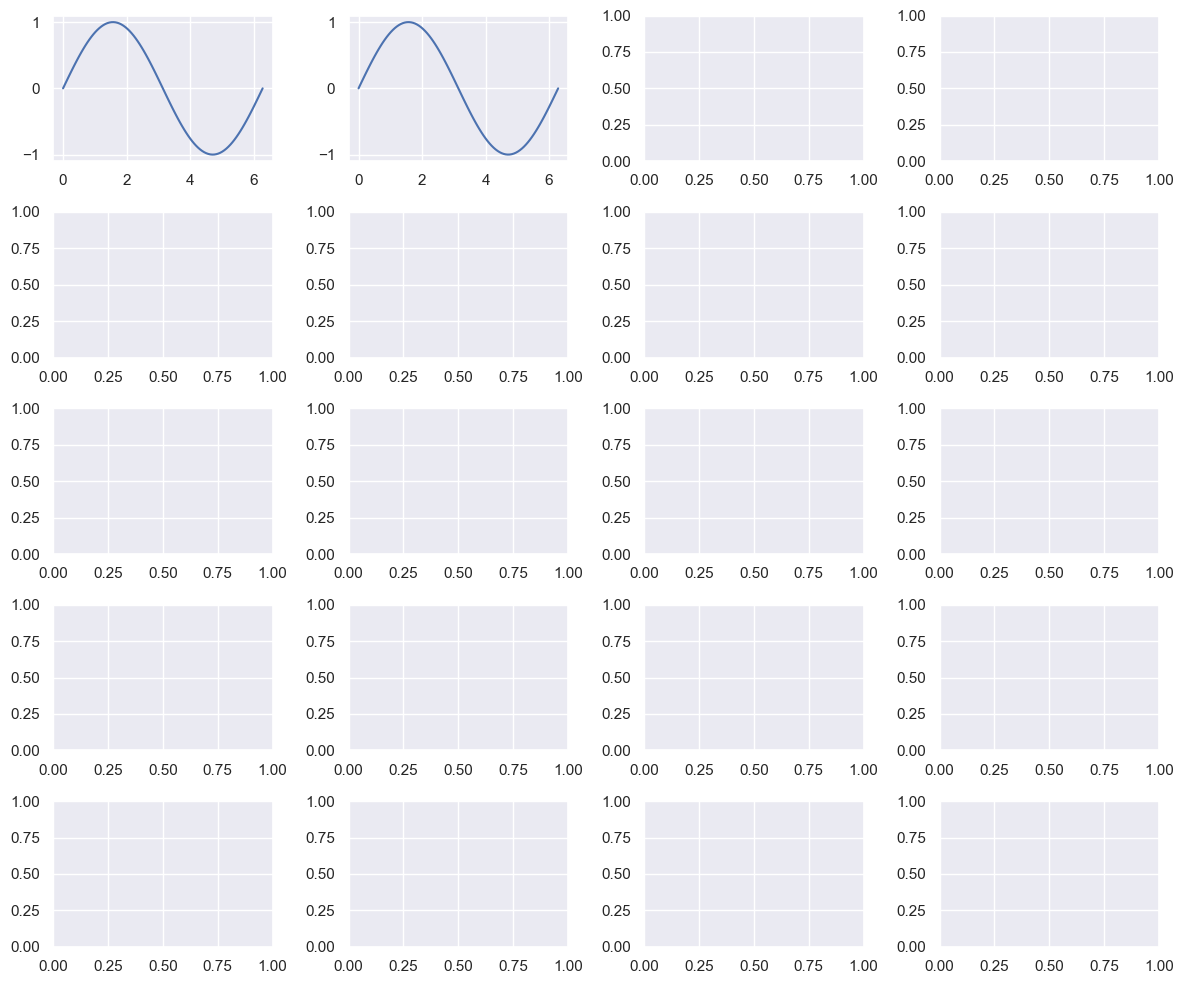

In [288]:
# Create a 5x4 grid of subplots
fig, axs = plt.subplots(5, 4, figsize=(12, 10))

# plot
axs[0, 0].plot(x, y)
axs[0, 1].plot(x, y)

plt.tight_layout()
plt.show()

# Correlation Analysis

## Ratings

### KW

In [36]:
genre_list = list(df.iloc[0, 11:20].values)
kw_dict = {}

for i in range(9):
    ratings_ses = pd.concat([ratings.iloc[:, i], original_ses], axis = 1)
    ratings_ses = ratings_ses[(ratings_ses[ratings_ses.columns[0]] != -1) & (ratings_ses[ratings_ses.columns[1]] != -1)]
    ratings_list = [ratings_ses[ratings_ses[ratings_ses.columns[1]] == i].iloc[:, 0] for i in range(1,6)]
    kw_dict[genre_list[i]] = scipy.stats.kruskal(*ratings_list).pvalue

In [37]:
kw_dict

{'Classical': 0.1562322468292185,
 'Country': 0.10570119772711711,
 'Electronic': 0.0005210514425996549,
 'Jazz': 0.04677395041334373,
 'Pop': 0.5993128890282292,
 'Rap/Hip-hop': 0.0015462263458019198,
 'Rock': 0.09424362939453995,
 'R&B/Soul': 0.00034491376660815784,
 'World/International': 0.0025102594438881397}

### Spearman r

In [38]:
r_dict = {}

for i in range(ratings.shape[1]):
    tmp = pd.concat([ratings.iloc[:, i], ses], axis = 1).astype(float)
    tmp = tmp[(tmp[tmp.columns[0]] != -1) & (tmp[tmp.columns[1]] != -1)]
    r_dict[genre_list[i]] = scipy.stats.spearmanr(tmp.iloc[:, 0], tmp.iloc[:, 1])

In [39]:
r_dict

{'Classical': SignificanceResult(statistic=-0.0027416679759382067, pvalue=0.9234136301800413),
 'Country': SignificanceResult(statistic=0.10490227394601813, pvalue=0.00022162795469314153),
 'Electronic': SignificanceResult(statistic=0.09669367836210711, pvalue=0.0006674823173185003),
 'Jazz': SignificanceResult(statistic=0.07140832108519952, pvalue=0.012208528635036388),
 'Pop': SignificanceResult(statistic=-0.006142563725705701, pvalue=0.8291250966454984),
 'Rap/Hip-hop': SignificanceResult(statistic=-0.021013243719367757, pvalue=0.461004292704835),
 'Rock': SignificanceResult(statistic=0.00866411985101781, pvalue=0.7608992145115663),
 'R&B/Soul': SignificanceResult(statistic=-0.09998863220360825, pvalue=0.00044002619219900724),
 'World/International': SignificanceResult(statistic=-0.07809816868718418, pvalue=0.005971800177368088)}

### Mann-Whitney U

In [40]:
U_dict = {}

for i in range(9):
    ratings_ses = pd.concat([ratings.iloc[:, i], original_ses], axis = 1)
    ratings_ses = ratings_ses[(ratings_ses[ratings_ses.columns[0]] != -1) & (ratings_ses[ratings_ses.columns[1]] != -1)]
    upper = ratings_ses[ratings_ses[ratings_ses.columns[1]] >= 3].iloc[:, 0]
    lower = ratings_ses[ratings_ses[ratings_ses.columns[1]] < 3].iloc[:, 0]
    U_dict[genre_list[i]] = scipy.stats.mannwhitneyu(upper.to_numpy().astype(int), lower.to_numpy().astype(int)).pvalue

In [41]:
U_dict

{'Classical': 0.30569159685780833,
 'Country': 0.01101810318946325,
 'Electronic': 6.806880718271089e-05,
 'Jazz': 0.005530442850928049,
 'Pop': 0.7445268340942288,
 'Rap/Hip-hop': 0.0012999486162199683,
 'Rock': 0.631601414272262,
 'R&B/Soul': 0.0006144134909208839,
 'World/International': 0.000967010178698744}

## Importance

### KW test

In [58]:
imp_ses = pd.concat([importance, ses], axis = 1)
imp_ses = imp_ses[(imp_ses[imp_ses.columns[0]] != -1) & (imp_ses[imp_ses.columns[1]] != -1)]
imp_list = [imp_ses[imp_ses[imp_ses.columns[1]] == i].iloc[:, 0] for i in range(1,6)]
imp_dict = {
    imp_ses.columns[0]: scipy.stats.kruskal(*imp_list).pvalue
} 

In [60]:
imp_dict

{'How important is music to you?': 0.04608935284102516}

### asd

### asd

## SES vs Environment

### KS Test

In [65]:
urban = ses_area[ses_area[ses_area.columns[1]] == "Urban"].iloc[:, 0].to_numpy().astype(int)
suburban = ses_area[ses_area[ses_area.columns[1]] == "Suburban"].iloc[:, 0].to_numpy().astype(int)
rural = ses_area[ses_area[ses_area.columns[1]] == "Rural"].iloc[:, 0].to_numpy().astype(int)

ks_dict = {
    "urban vs suburban" : scipy.stats.ks_2samp(urban, suburban),
    "suburban vs rural" : scipy.stats.ks_2samp(suburban, rural),
    "rural vs urban" : scipy.stats.ks_2samp(rural, urban),
}

In [66]:
ks_dict

{'urban vs suburban': KstestResult(statistic=0.33950911473847256, pvalue=6.158938960106663e-33, statistic_location=3, statistic_sign=-1),
 'suburban vs rural': KstestResult(statistic=0.20316338296485686, pvalue=0.016879619814214417, statistic_location=1, statistic_sign=-1),
 'rural vs urban': KstestResult(statistic=0.3782999787098148, pvalue=1.2374523017712157e-07, statistic_location=2, statistic_sign=1)}